In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import different modules for using with the notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

from sklearn.linear_model import LogisticRegression as logis
from sklearn.metrics import confusion_matrix

# Generate training data

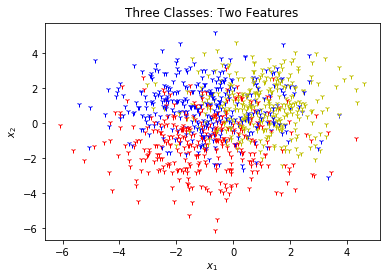

In [35]:
# Training data - three randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.randint(low=0, high=2+1, size = N)
# Mean of each cluster
means = np.array([[-1, 1, -1], [-1, 1, 1],])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 3)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])

# Plot the data
#print(X.shape[1]) number of all markers
c = np.array(["r","y","b"])#array of characters we want to split into
for k in range(X.shape[1]):#k to 1000
    plt.plot(X[0,k],X[1,k],c[y[k]]+"1")#'1' is for the marker shape
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Three Classes: Two Features")
plt.show()

X = X.T

#### Display the data that you generated to find something like the following:

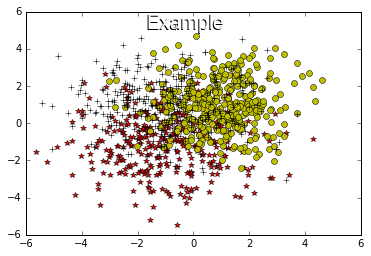

In [4]:
display(Image(filename='./images/wm_dat1.png'))

# Fit the training data to the scikit-learn softmax classifier

The image above shows that there is considerable overlap between the classes. Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:**

In [41]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[252  35  50]
 [ 36 249  50]
 [ 73  74 181]]
Confusion matrix, without normalization
[[252  35  50]
 [ 36 249  50]
 [ 73  74 181]]


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


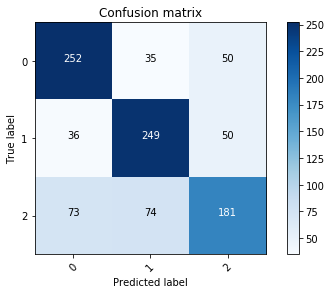

In [47]:
#code for "Fit the training data to the scikit-learn softmax classifier"
c1 = np.array(["0","1","2"])#to match given image
clf = logis()#for multiple dimensions
clf.fit(X, y)#actual fit
y_pred = clf.predict(X)#predict using logis
cm = confusion_matrix(y,y_pred)#make a confusion matrix
print(cm)
plot_confusion_matrix(cm,c1,False)#false is non-normalised, true/not stated is normalised

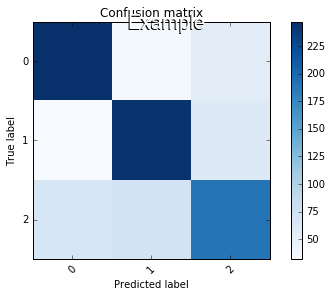

In [18]:
display(Image(filename='./images/wm_confusion.png'))

**Now plot the different classes as predicted by your system. You should get something like:** 

**Can you tell from the graph that this is a *linear* classifier?**

IndexError: index 2 is out of bounds for axis 1 with size 2

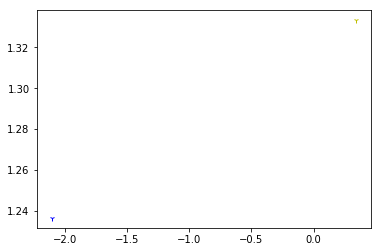

In [57]:

c = np.array(["r","y","b"])#array of characters we want to split into
for k in range(X.shape[0]):#k to 1000
    plt.plot(X[0,k],X[1,k],c[y_pred[k]]+"1")#'1' is for the marker shape
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Three Classes: Two Features")
plt.show()

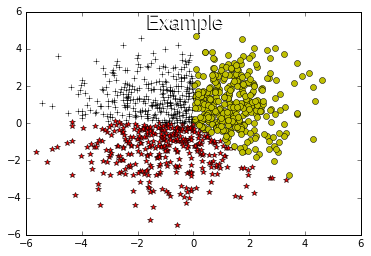

In [19]:
display(Image(filename='./images/wm_dat2.png'))

# Implement a Naive Bayes Classifier

Implement your own Naive Bayes Classifier (from first principles). Train it using the exact same data you used for the previous question (write it in a seperate python file which you can import into the notebook). Implement it in a generic way, i.e. it should be able to work on $d$ dimensional data and it should not be limited to a certain amount of classes.

Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:**

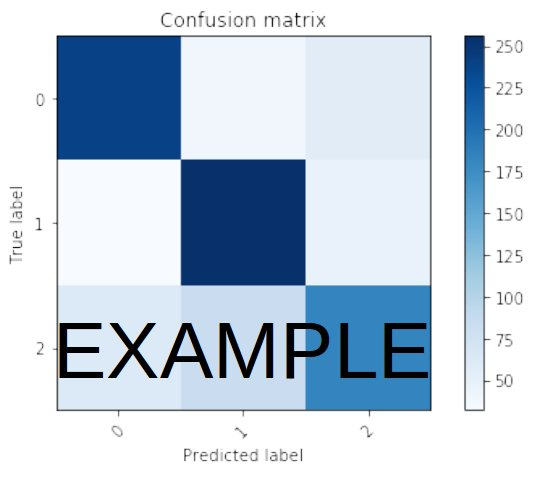

In [20]:
display(Image(filename='./images/conf_mat_bayes.jpg'))

**Now plot the different classes as predicted by your system. You should get something like:**

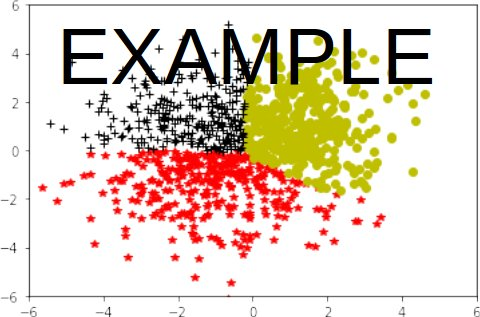

In [21]:
display(Image(filename='./images/predict_bayes.jpg'))

# Implement a Logistic Regression Classifier

Implement your own Logistic Regression classifier (from first principles). It should be generic and be able to work on $d$ dimensional data (and two classes). Please make your implementation as modular as possible, having a seperate function for the Hessian and the gradient vector (write it in a seperate python file which you can import into the notebook). A regularization term based on a Gaussian prior (with zero mean and covariance matrix $\lambda\mathbf{I}$) must be included.  Optionally, a bias term also needs to be incorporated into your classifier - this can be implemented by augmenting the training dataset with an additional all-one feature.

**Now train your classifier using the following data.**

In [22]:
# Training data - two randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.randint(low=0, high=2, size = N)
# Mean of each cluster
means = np.array([[-1, 1], [-1, 1],])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 2)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])

Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:** 

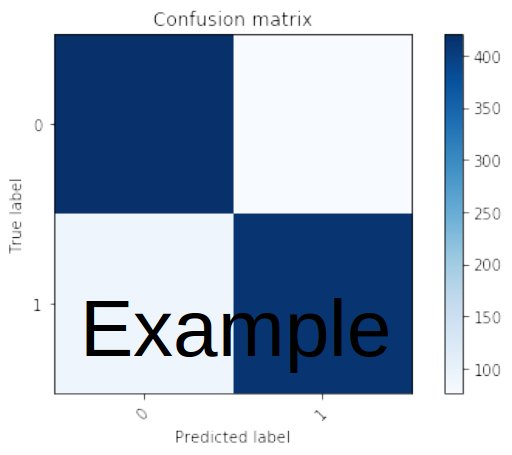

In [23]:
display(Image(filename='./images/conf_mat_logreg.jpg'))

**Now plot the different classes as predicted by your system. Add your decision boundary to the same plot. You should get something like:**

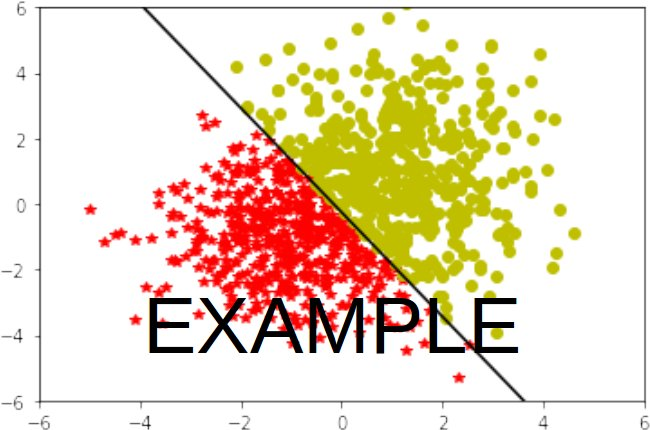

In [24]:
display(Image(filename='./images/predict_logreg.jpg'))

** Before continuing in the notebook, you will need to install the `lasagne` Python module with "pip3 install --user lasagne" **

# Now classify the MNIST digits 

The MNIST database provided in the assignment resources consists of low-resolution (28x28) grayscale images of handwritten digits ($0,1,2,3,4,5,6,7,8,9$). First, you read in a set of training digits and display them interactively to get an idea what they look like. Afterwards, you build and train a softmax classifier using scitkit-image and scikit-learn. You will then classify the digits in the test set and display the results. Finally, you will display the weights as images.

First load the dataset - for more information about the dataset, see http://yann.lecun.com/exdb/mnist/.

In [25]:
from mnist import load_dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()

## Display the test digits interactively.

In [26]:
from ipywidgets import interact
def show_digits(k=0):
    """
    Show the first 1000 digits in the training set
    """
    
    plt.imshow(X_train[k][0], cmap=cm.binary)   
    
    plt.show()
    
w = interact(show_digits, k =(0, 1000)) 


AttributeError: 'numpy.ndarray' object has no attribute 'binary'

## Train the softmax classifier

**Using the training set, build a softmax classifier. Use this classifier to classify the digits in the training set and the test set separately. Print the confusion matrix and also display it as an image for each case to get something like:**

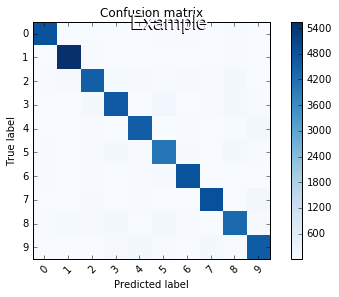

In [27]:
display(Image(filename='./images/wm_confusion2.png'))

### Accuracy

**Calculate the accuracy of your system as a fraction of the correctly classified digits. You should get something like 0.9254. use - `logis(C=1e5, solver='lbfgs', multi_class='multinomial')`**

## Extracting the weights and display as images.

**Extract the weights of the softmax classifier and display them as images. Each set of weights should correspond to a specific digit**. 

**As an example the weight image associated with the 0 digit should look similar to this:**

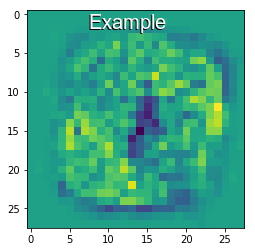

In [28]:
display(Image(filename='./wm_softmax_mnist_weights/wm_0.png'))

## Further investigation

Fit the softmax classifier for different values of the regularization parameter - we recommend values evenly spaced on the log scale - and show the corresponding weight images for some digit as the parameter changes.  Explain the changes in the weight images observed. Moreover, plot the accuracy of your classifier as a function of the regularization parameter. Use this plot to expand on your answer.